In [31]:
from pathlib import Path

import pandas as pd

raw_data = pd.concat(
    [pd.read_csv(f, delimiter="\t") for f in Path("data/reaxys/raw/").glob("*.tsv")], ignore_index=True
)

raw_data["reactant"] = raw_data["Reaction"].str.split(">>").str[0]
raw_data["product"] = raw_data["Reaction"].str.split(">>").str[-1]
raw_data["reactant_count"] = raw_data["reactant"].str.split(".").str.len()
raw_data = raw_data[raw_data["reactant_count"] != 1]
raw_data = raw_data[raw_data["reactant_count"] < 3]

In [32]:
import numpy as np

# Split the reactants into two columns
raw_data[["reactant_1", "reactant_2"]] = raw_data["reactant"].str.split(".", n=1, expand=True)

# List of halogens (electrophiles)
halogens = ["Cl", "Br"]


# Function to identify electrophile and nucleophile
def classify_reactants(reactant_1: str, reactant_2: str) -> tuple:
    """Classify the reactants as electrophile and nucleophile.

    Args:
        reactant_1 (str): The first reactant.
        reactant_2 (str): The second reactant.

    Returns:
        tuple: The electrophile and nucleophile.
    """
    if any(hal in reactant_1 for hal in halogens):
        return reactant_1, reactant_2  # reactant_1 is electrophile
    elif any(hal in reactant_2 for hal in halogens):
        return reactant_2, reactant_1  # reactant_2 is electrophile
    else:
        print(f"Neither reactant is an electrophile: {reactant_1}, {reactant_2}")
        return np.nan, np.nan  # Neither are electrophiles


# Apply the classification function
raw_data[["electrophile", "nucleophile"]] = raw_data.apply(
    lambda row: classify_reactants(row["reactant_1"], row["reactant_2"]), axis=1, result_type="expand"
)

# Drop rows where neither reactant is identified as an electrophile
raw_data = raw_data.dropna(subset=["electrophile", "nucleophile"])

# Optionally drop the intermediate columns
raw_data = raw_data.drop(columns=["reactant_1", "reactant_2"])

raw_data[["electrophile", "nucleophile"]]

,electrophile,nucleophile
0,CC1=NN(C2=CC(Cl)=NC=C12)C1=CC=CC(F)=C1,[H][C@@](C)(N)C1=CC=CC=C1
1,CC1=NN(C2=CC(Cl)=NC=C12)C1=CC=C(F)C=C1,[H][C@@](C)(N)C1=CC=CC=C1
2,CC1=NN(C2=CC(Cl)=NC=C12)C1=CC=CC(Cl)=C1,[H][C@@](C)(N)C1=CC=CC=C1
3,CC(C)C1=CC(=CC=C1)N1N=C(C)C2=CN=C(Cl)C=C12,[H][C@@](C)(N)C1=CC=CC=C1
4,CC1=NN(C2=CC(Cl)=NC=C12)C1=CC=CC(=C1)C#N,[H][C@@](C)(N)C1=CC=CC=C1
...,...,...
13402,CC1=CC=C(C=C1)S(=O)(=O)OC1=NC=C(Br)C=C1,CC1=C(N)C=CC=C1
13403,CC1=CC=C(C=C1)S(=O)(=O)OC1=NC=C(Br)C=C1,CC1=CC=CC(N)=C1
13404,CC1=CC=C(C=C1)S(=O)(=O)OC1=NC=C(Br)C=C1,NC1=C2C=CC=CC2=CC=C1
13405,CC1=CC=C(C=C1)S(=O)(=O)OC1=NC=C(Br)C=C1,NC1=CC=C(F)C=C1


In [33]:
data = raw_data[["electrophile", "nucleophile", "product"]]

unique_elec = data["electrophile"].unique()
unique_nuc = data["nucleophile"].unique()
unique_prod = data["product"].unique()

print(f"Unique electrophiles: {len(unique_elec)}")
print(f"Unique nucleophiles: {len(unique_nuc)}")
print(f"Unique products: {len(unique_prod)}")

Unique electrophiles: 4731
Unique nucleophiles: 3333
Unique products: 11920


In [34]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True


def convert_smiles(smiles: str) -> Chem.Mol:
    """Convert a SMILES string to an rdkit mol object.

    Args:
        smiles (str): The SMILES string.

    Returns:
        Chem.Mol: The rdkit mol object.
    """
    mol = Chem.MolFromSmiles(smiles)
    try:
        Chem.SanitizeMol(mol)
    except Exception:
        return None
    if mol is None:
        return None
    smiles = Chem.MolToSmiles(mol, canonical=True)
    return smiles, mol


data[["electrophile", "electrophile_mol"]] = pd.DataFrame(
    data["electrophile"].apply(lambda x: convert_smiles(x)).tolist(), index=data.index
)
data[["nucleophile", "nucleophile_mol"]] = pd.DataFrame(
    data["nucleophile"].apply(lambda x: convert_smiles(x)).tolist(), index=data.index
)
data[["product", "product_mol"]] = pd.DataFrame(
    data["product"].apply(lambda x: convert_smiles(x)).tolist(), index=data.index
)

data = data.dropna()

[15:40:06] Explicit valence for atom # 12 N, 4, is greater than permitted
/tmp/ipykernel_1755/3084265570.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["electrophile", "electrophile_mol"]] = pd.DataFrame(
/tmp/ipykernel_1755/3084265570.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[["electrophile", "electrophile_mol"]] = pd.DataFrame(
[15:40:09] Explicit valence for atom # 5 N, 5, is greater than permitted
/tmp/ipykernel_1755/3084265570.py:30: SettingWithCopyWarning: 
A value is tryin

In [35]:
from rdkit.Chem import Descriptors

data["product_mw"] = data["product_mol"].apply(Descriptors.ExactMolWt)
print(data["product_mw"].describe())
data = data[data["product_mw"] < 600]
data.drop(columns=["product_mw"], inplace=True)
print(f"Number of reactions: {len(data)}")

count    12695.000000
mean       401.546850
std        135.475595
min        107.073499
25%        300.031404
50%        395.045299
75%        490.211627
max       1201.685821
Name: product_mw, dtype: float64
Number of reactions: 11811


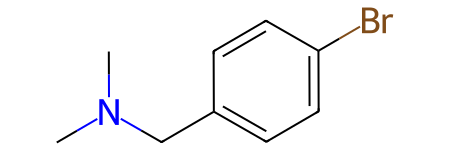

In [36]:
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import IPythonConsole

rdDepictor.SetPreferCoordGen(True)
IPythonConsole.ipython_useSVG = True

index = 900

data["electrophile_mol"].iloc[index]

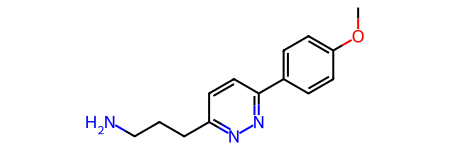

In [37]:
data["nucleophile_mol"].iloc[index]


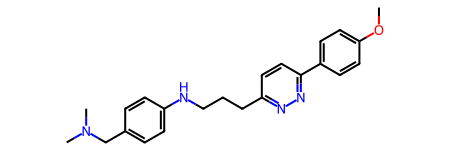

In [38]:
data["product_mol"].iloc[index]

In [40]:
print(f"Size of dataset: {len(data)}")
data.drop_duplicates(subset=["electrophile", "nucleophile", "product"], inplace=True)
print(f"Size of dataset after removing duplicates: {len(data)}")

print(f"Number of unique electrophiles: {len(data['electrophile'].unique())}")
print(f"Number of unique nucleophiles: {len(data['nucleophile'].unique())}")
print(f"Number of unique products: {len(data['product'].unique())}")

Size of dataset: 11321
Size of dataset after removing duplicates: 11321
Number of unique electrophiles: 4416
Number of unique nucleophiles: 3044
Number of unique products: 11071


In [53]:
data["rxn_id"] = data.apply(lambda x: f"L{x.name}", axis=1)
data[["rxn_id", "electrophile", "nucleophile", "product"]].to_csv(
    "data/reaxys/literature_reactions.tsv",
    index=False,
    header=["rxn_id", "startingmat_1_smiles", "startingmat_2_smiles", "product_1_smiles"],
    sep="\t",
)